# Metis - Project Kojak: Price Optimization

# Table of contents
1. [Introduction](#introduction)
2. [Background](#Background)
3. [Optimal Price Point](#Optimal Price Point)
4. [Dataframe Setup for Prediction Analysis ](#Dataframe Setup for Prediction Analysis )
5. [Conclusion](#Conclusion)

 ## Introduction <a name="introduction"></a>

Created a tool for the public company "Central Garden & Pet" to choose an optimal price point for it's pet products based on past performance, and set up their Nielsen data in an optimal way for making future price predictions. Note, due to confidentiality, certain information is left out of this presentation. 

Imports

In [1]:
# general
import os
import json
import pickle
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from IPython.display import Image

# sklearn
from sklearn import metrics
from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


# graphing
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import seaborn as sns
from seaborn import plt
import patsy

import warnings
warnings.filterwarnings('ignore')

/Users/Cronin/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


 ## Background <a name="Background"></a>

### Central Garden & Pet

* Central Garden & Pet (NASDAQ (Ticker: CENT) is a leading innovator, marketer, and producer of quality branded pet products to major and independent retailers nationwide.

### Nielsen Data

* This project analyzes weekly Nielsen retail pricing data for many retailers (including Central Garden & Pet) over the last three years. Nielsen collects this data to create a picture of the total market. 
* It includes 80 different price & volume identifiers based on promotional, non-promotional, and average/base prices each week for current and previous year.
* Data focuses on Central Garden & Pet's small animal food business segment, which amounts to approximately 60,000 rows.
* Created price elasticity scores for each price point based on historcial price. A price elasticy of 5 means a 1% increase in price leads to a 5% decrease in quantity. It is based off of the following formula:

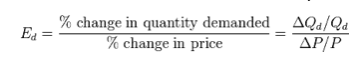

In [2]:
Image(filename='elasticity.png')

 ## Dataframe Preparation <a name="Dataframe Preparation"></a>

Read in the data

In [3]:
df = pd.read_csv('petfood_projectkojak.csv')

Function to clean and standardize column names

In [4]:
def clean_names(columns):
    columns = [str(col).lower().replace('[', '').replace(']', '').replace(' ', '_').replace('$', 'usd').replace('%', 'percent_') 
               for col in columns]
    return columns

In [5]:
df.columns = clean_names(df.columns)

Creating of dummy variable columss for categorical features. Each new dataframe is merged with the previous dataframe.

In [6]:
df_market = pd.get_dummies(df['market'])
df_new = pd.concat([df, df_market], axis=1)
df_size = pd.get_dummies(df_new['base_size'])
df_new0 = pd.concat([df_new, df_size], axis=1)
df_years = pd.get_dummies(df_new0['year'])
df_new1 = pd.concat([df_new0, df_years], axis=1)
df_brand_high = pd.get_dummies(df_new1['brand_high'])
df_new2 = pd.concat([df_new1, df_brand_high], axis=1)
df_target_animal = pd.get_dummies(df_new2['target_animal'])
df_new3 = pd.concat([df_new2, df_target_animal], axis=1)
df_new3.columns = clean_names(df_new3.columns)

In [7]:
df_cgp = df_new3

 ## Optimal Price Point <a name="Optimal Price Point"></a>

An small animal food product is looked at through its unique UPC code, which takes in to account the product's market, brand, sub brand, size, and animal. Central Garden & Pet's small animal food brand is called "Kaytee". Here's a diagram that illustrates a product UPC code. Note, the red circles represent how many unique items there are. For example, there are 110 different sub brands. 

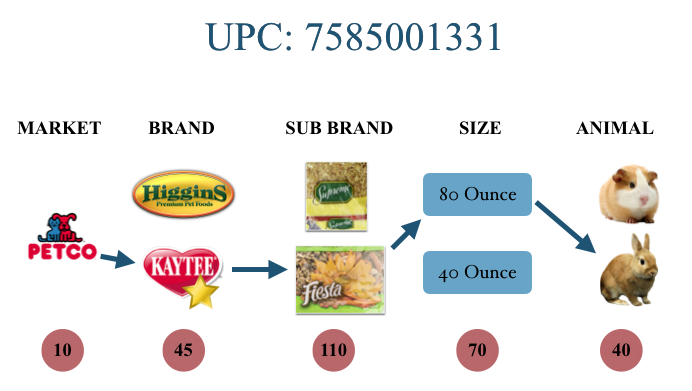

In [8]:
Image(filename='upc.png')

### Function that finds optimal price point

In [9]:
def find_optimal(df):
    x = np.array(list(df.avg_unit_price))
    y = np.array(list(df.usd))
    x_df = pd.DataFrame(x)
    y_df = pd.DataFrame(y)
    degree = 3 # Set the degree of our polynomial
    # Generate the model type with make_pipeline. First step is to generate # degree polynomial features 
    # in the input features and then run a linear regression on the resulting features.
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(x_df, y_df) # Fit our model to the training data
    range_min = x.mean() - 1*x.std()
    range_max = x.mean() + 1*x.std()
    x0 = np.arange(range_min, range_max, .05, dtype=None)
    x_df0 = pd.DataFrame(x0)
    pred0 = est.predict(x_df0)
    max_index = np.argmax(pred0)
    return x0[max_index] 

### Example of how optimal price function works

In [10]:
df_cgp_petsmart_sku = df_cgp.ix[df_cgp.upc == 2685100451, :]

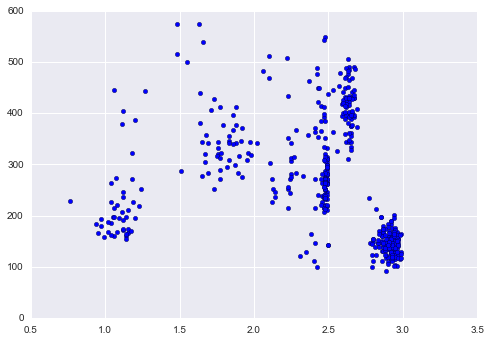

In [11]:
df_cgp_petsmart_sku = df_cgp.ix[df_cgp.upc == 2685100451, :]
plt.scatter(df_cgp_petsmart_sku.avg_unit_price, df_cgp_petsmart_sku.units)

In [12]:
x = np.array(list(df_cgp_petsmart_sku.avg_unit_price))
y = np.array(list(df_cgp_petsmart_sku.usd))
z = np.polyfit(x, y, 3)
x_df = pd.DataFrame(x)
y_df = pd.DataFrame(y)

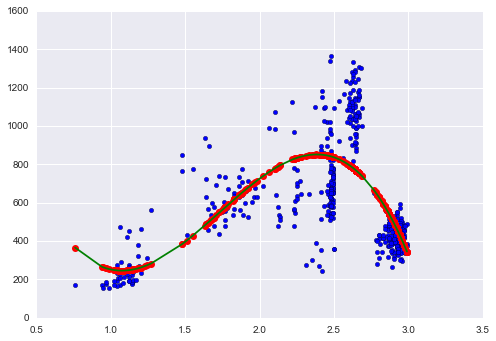

In [13]:
# Set up the plot
fig,ax = plt.subplots(1,1)
degree = 3
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
est.fit(x_df, y_df)
# Plot the results
pred = est.predict(x_df)
plt.scatter(x_df,y_df)
plt.plot(x,pred,'or')
# Sort the data to plot it
x_sorted = sorted(x_df.values.T.tolist()[0])
pred_sorted = [j for (i, j) in sorted(zip(x_df.values.flatten().T.tolist(), pred.flatten().tolist()))]
plt.plot(x_sorted, pred_sorted,'-g')

Optimal Price Graph:
* Price vs. Revenue
* Create Range of 1 standard deviation
* Fit third degree polynomial line
* Find optimal point

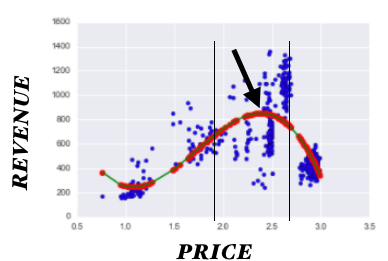

In [14]:
Image(filename='upcoptimal.png')

### Implement optimal price function in df_upc dataframe 

Set new optimal price column filled with zeros

In [15]:
df_cgp['opt_price'] = pd.Series(np.zeros(len(df_cgp)))

Create product path to filter required data. A upc code can be the same for different markets and brands so to filter Central Garden and Pet's Kaytee brand, we create a path filtered also by market and brand_high.

In [16]:
paths = pd.unique(df_cgp[['market', 'brand_high', 'upc']].values)

The code below finds the optimal price for a product and puts into a the new column "opt_price". Works if there are at least 10 data points and if prices don't vary, it gives the average unit price.

In [17]:
threshold = 10
for path in paths:
    df_path = df_cgp[(df_cgp.market == path[0]) & (df_cgp.brand_high == path[1]) & (df_cgp.upc == path[2])]
    num_records = len(df_path)
    #print upc
    if num_records < threshold:
        continue
    if len(df_path.avg_unit_price.unique()) == 1:
        price = df_path.avg_unit_price.iloc[0]
    else:
        price = find_optimal(df_path)
    df_cgp.loc[(df_cgp.market == path[0]) & (df_cgp.brand_high == path[1]) & (df_cgp.upc == path[2]), 'opt_price'] = price

 ## Dataframe Setup for Prediction Analysis <a name="Dataframe Setup for Prediction Analysis"></a>

Filtering of the df_cpg to include only one market segment: Total US Market

In [18]:
df_cgp = df_cgp[df_cgp.market=='Total US Market']

Filtering Total US Market dataframe into two dataframes. One which includes Central Garden & Pet's brand "Kaytee" and the other which includes all other competitor brands. 

In [19]:
df_kaytee = df_cgp[df_cgp.brand_high=='KAYTEE']
df_notkaytee = df_cgp[df_cgp.brand_high!='KAYTEE']

Function to convert "week" column into datetime

In [20]:
def convert_weeks(val):
    return val[-8:]
df_kaytee["weeks_dt"] = pd.to_datetime(df_kaytee.loc[:, "weeks"].map(convert_weeks))
df_notkaytee["weeks_dt"] = pd.to_datetime(df_notkaytee.loc[:, "weeks"].map(convert_weeks))

Sort dataframes by week

In [21]:
df_kaytee.sort_values(["market", "upc", "weeks_dt"], inplace=True)
df_notkaytee.sort_values(["market", "upc", "weeks_dt"], inplace=True)

* Example code that uses .shift() method to add previous week price data in same row as current week price data. Here's an example of the code on one price category "avg_pe_normal". 
* The Kaytee Dataframe will now have three new columns: week1_avg_pe_normal, week2_avg_pe_normal, week3_avg_pe_normal.
* Do this for every price point and for more than three weeks to get complete picture to analyze

In [22]:
# avg pe normal
df_kaytee["week1_avg_pe_normal"] = df_kaytee.groupby(["market", "upc"]).avg_pe_normal.shift(1)
df_kaytee["week2_avg_pe_normal"] = df_kaytee.groupby(["market", "upc"]).avg_pe_normal.shift(2)
df_kaytee["week3_avg_pe_normal"] = df_kaytee.groupby(["market", "upc"]).avg_pe_normal.shift(3)

Function adds average price for competitor pricing ('competitor_both' column) filtered by market, upc, and week like above

In [ ]:
def get_competitor_prices(row):
    for week, week_comp_pe in [("week1", "week1_avg_pe_normal_comp"),
                               ("week2", "week2_avg_pe_normal_comp"),
                               ("week3", "week3_avg_pe_normal_comp")]:
        values = [df_notkaytee.loc[(df_notkaytee["weeks"] == row[week]) 
                     & (df_notkaytee["upc"] == int(comp_upc)) 
                     & (df_notkaytee["market"] == row["market"]), 
                     "avg_pe_normal"].values
        for comp_upc in row["competitor_both"].split(",")]
        values = [val[0] for val in values if len(val) > 0]
        if values:
            row[week_comp_pe] = np.mean(values)
        else:
            row[week_comp_pe] = np.nan
    return row
df_kaytee_comp = df_kaytee.apply(get_competitor_prices, axis="columns")

 ## Conclusion <a name="Conclusion"></a>

This project took real-world Nielsen retail data and created a tool for Central Garden & Pet to choose an optimal price for its products based on historical weekly prices and revenue. It then setup the data in an optimal way to make weekly predictions on what prices to set by adding previous week prices as additional columns for each unique price identifier. It similarly did this with competitor prices. These additional data points, along with other volume and price feature columns, can then be used with predictive models to set a future price. Due to timing restraints, this project didn't get to include analysis of predictive models on the data. 